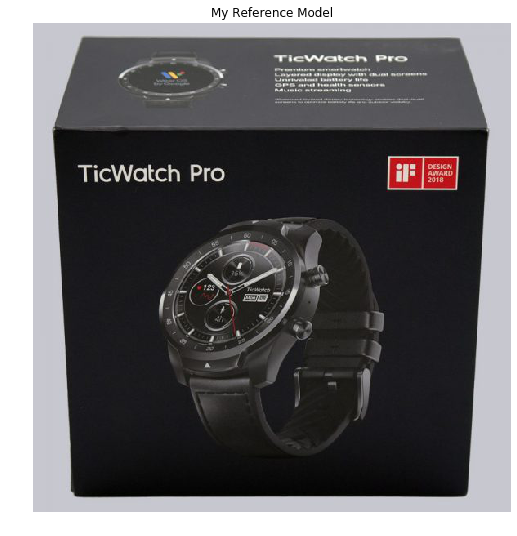

In [8]:
import argparse
import cv2
import numpy as np
import math
import os
from matplotlib import pyplot as plt

img = cv2.imread('o_tic.jpg')
       
plt.rcParams['figure.figsize'] = (16,9)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('My Reference Model')
plt.axis('off')
plt.show()

In [ ]:

class OBJ:
    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(list(map(float, values[1:3])))
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                self.faces.append((face, norms, texcoords))

MIN_MATCHES = 10  


def main():
    homography = None
    camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])
    orb = cv2.ORB_create()
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    dir_name = os.getcwd()
    model = cv2.imread(os.path.join(dir_name, 'o_tic.jpg'), 0)
    kp_model, des_model = orb.detectAndCompute(model, None)
    obj = OBJ(os.path.join(dir_name, 'fox.obj'), swapyz=True)
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    fshape = frame.shape
    fheight = fshape[0]
    fwidth = fshape[1]
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (fwidth, fheight))

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Unable to capture video")
            return
        kp_frame, des_frame = orb.detectAndCompute(frame, None)
        matches = bf.match(des_model, des_frame)
        matches = sorted(matches, key=lambda x: x.distance)

        if len(matches) > MIN_MATCHES:
            src_pts = np.float32([kp_model[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            if args.rectangle:
                h, w = model.shape
                pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                dst = cv2.perspectiveTransform(pts, homography)
                frame = cv2.polylines(frame, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
            if homography is not None:
                try:
                    projection = projection_matrix(camera_parameters, homography)
                    frame = render(frame, obj, projection, model, False)
                except:
                    pass
            if args.matches:
                frame = cv2.drawMatches(model, kp_model, frame, kp_frame, matches[:10], 0, flags=2)

            out.write(frame)
            cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            print("Not enough matches found - %d/%d" % (len(matches), MIN_MATCHES))

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return 0

def render(img, obj, projection, model, color=False):
    vertices = obj.vertices
    scale_matrix = np.eye(3) * 3
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1]
            cv2.fillConvexPoly(img, imgpts, color)

    return img

def projection_matrix(camera_parameters, homography):
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return tuple(int(hex_color[i:i + h_len // 3], 16) for i in range(0, h_len, h_len // 3))

parser = argparse.ArgumentParser(description='Augmented reality application')

parser.add_argument('-r','--rectangle', help = 'draw rectangle delimiting target surface on frame', action = 'store_true')
parser.add_argument('-mk','--model_keypoints', help = 'draw model keypoints', action = 'store_true')
parser.add_argument('-fk','--frame_keypoints', help = 'draw frame keypoints', action = 'store_true')
parser.add_argument('-ma','--matches', help = 'draw matches between keypoints', action = 'store_true')

args = parser.parse_args()

if __name__ == '__main__':
    main()